In [1]:
import math
import random
import tensorflow as tf
from tensorflow.python.layers.core import Dense
import numpy as np
tf.__version__

/DevTools/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


'1.4.0'

In [2]:
class Seq2Seq(object):
    def __init__(self, vocab_size, embedding_size, num_units, num_layers, out_keep_prob, batch_size, encoder_size, decoder_size, start_of_sequence_id, end_of_sequence_id, pad_of_sequence_id, dull_set, learning_rate=0.0001, use_attention=False):
        print('Init new model')
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_units = num_units
        self.num_layers = num_layers
        self.out_keep_prob = out_keep_prob
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.time_major = True
        self.use_attention = use_attention
        self.global_step = tf.Variable(0, trainable=False)
        self.counter = tf.Variable(0, name='counter')
        
        self.encoder_size = encoder_size
        self.decoder_size = decoder_size
        self.start_of_sequence_id = start_of_sequence_id
        self.end_of_sequence_id = end_of_sequence_id
        self.pad_of_sequence_id = pad_of_sequence_id
        
        self.dull_set = dull_set
        
    def createCell(self, num_units, num_layers):
        #return tf.contrib.rnn.BasicLSTMCell(num_units)
        cells = []
        for _ in range(self.num_layers):
            cell = tf.contrib.rnn.LSTMCell(self.num_units)  # Or LSTMCell(num_units)
            cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=self.out_keep_prob)
            cells.append(cell)
        stacked_cell = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=True)
        return stacked_cell
    
    
    def build(self):
        self._init_placeholders()
        self._init_embeddings()
        #self._init_encoder()
        self._init_bidirectional_encoder()
        self._init_decoder()
        self._init_optimizer()
        self.saver = tf.train.Saver(tf.global_variables())
        
        
    def _init_placeholders(self):
        self.encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
        self.decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')
        self.decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')
        
        self.source_sequence_length = tf.placeholder(tf.int32, (None,), name='source_sequence_length')
        self.target_sequence_length = tf.placeholder(tf.int32, (None,), name='target_sequence_length')
        
        self.max_target_sequence_length = tf.reduce_max(self.target_sequence_length, name='max_target_length')
        
        self.reward = tf.placeholder(tf.float32, name="reward")
        
        
    def _init_embeddings(self):
        with tf.variable_scope("embedding") as scope:
            # Uniform(-sqrt(3), sqrt(3)) has variance=1.
            sqrt3 = math.sqrt(3)
            initializer = tf.random_uniform_initializer(-sqrt3, sqrt3)
            
            self.embedding_matrix = tf.get_variable(
                                        name="embedding_matrix",
                                        shape=[self.vocab_size, self.embedding_size],
                                        initializer=initializer,
                                        dtype=tf.float32
                                    )
            
            self.embeddings = tf.Variable(tf.random_uniform([self.vocab_size, self.embedding_size], -1.0, 1.0), dtype=tf.float32)
            self.encoder_inputs_embedded = tf.nn.embedding_lookup(self.embedding_matrix, self.encoder_inputs)
            self.decoder_inputs_embedded = tf.nn.embedding_lookup(self.embedding_matrix, self.decoder_inputs)
            
            #self.encoder_inputs_embedded = tf.contrib.layers.embed_sequence(self.encoder_inputs, self.vocab_size, self.embedding_size)
            #self.embedding_matrix = tf.Variable(tf.random_uniform([self.vocab_size, self.embedding_size]))
            #self.decoder_inputs_embedded = tf.nn.embedding_lookup(self.embedding_matrix, self.decoder_inputs)
    
    
    def _init_encoder(self):
        with tf.variable_scope("encoder") as scope:
            self.encoder_cell = self.createCell(self.num_units, self.num_layers)
            self.encoder_outputs, self.encoder_state = tf.nn.dynamic_rnn(
                                                                        cell=self.encoder_cell,
                                                                        inputs=self.encoder_inputs_embedded,
                                                                        dtype=tf.float32,
                                                                        sequence_length=self.source_sequence_length,
                                                                        time_major=self.time_major
                                                                    )
    
    
    def _init_bidirectional_encoder(self):
        with tf.variable_scope("bidirectional_encoder") as scope:
            num_bi_layers = int(self.num_layers / 2)
            self.encoder_cell_fw = self.createCell(self.num_units, num_bi_layers)
            self.encoder_cell_bw = self.createCell(self.num_units, num_bi_layers)
            
            encoder_outputs, bi_encoder_state = tf.nn.bidirectional_dynamic_rnn(
                                                                cell_fw=self.encoder_cell_fw,
                                                                cell_bw=self.encoder_cell_bw,
                                                                inputs=self.encoder_inputs_embedded,
                                                                dtype=tf.float32,
                                                                sequence_length=self.source_sequence_length,
                                                                time_major=self.time_major,
                                                                swap_memory=True
                                                            )
            #self.encoder_outputs = tf.concat(outputs, -1)
            #self.encoder_state = states
            #if num_bi_layers == 1:
            #    self.encoder_state = bi_encoder_state
            #else:
            # alternatively concat forward and backward states
            self.encoder_state = []
            for layer_id in range(num_bi_layers):
                self.encoder_state.append(bi_encoder_state[0][layer_id])  # forward
                self.encoder_state.append(bi_encoder_state[1][layer_id])  # backward
            self.encoder_state = tuple(self.encoder_state)
                
            self.encoder_outputs = tf.concat(encoder_outputs, -1)
            
            
    def _init_decoder(self):

        output_layer = Dense(self.vocab_size,
                         kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))
        
        with tf.variable_scope("decoder") as scope:
            
            if self.use_attention:
                #attention_states: [batch_size, max_time, num_units] (not time_major)
                if self.time_major:
                    attention_states = tf.transpose(self.encoder_outputs, [1, 0, 2])
                else:
                    attention_states = self.encoder_outputs

                # Create an attention mechanism
                attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                                    num_units=self.num_units, memory=attention_states,
                                    memory_sequence_length=self.source_sequence_length)
                
                stacked_cell = self.createCell(self.num_units, self.num_layers)
                #attention_cell= tf.contrib.rnn.BasicLSTMCell(self.num_units)
                attention_cell = tf.contrib.seq2seq.AttentionWrapper(
                                                                    cell=stacked_cell,
                                                                    attention_mechanism=attention_mechanism,
                                                                    attention_layer_size=self.num_units,  # don't add an additional dense layer.
                                                                    output_attention=False)
                #self.decoder_cell= GNMTAttentionMultiCell(attention_cell, cells)
                
                self.decoder_cell = attention_cell

                initial_state = self.decoder_cell.zero_state(self.batch_size, tf.float32).clone(cell_state=self.encoder_state)
                #initial_state = self.decoder_cell.zero_state(dtype=tf.float32, batch_size=self.batch_size)
            else:
                self.decoder_cell = self.createCell(self.num_units, self.num_layers)
                initial_state =self.encoder_state
            
            # Helper for the training process. Used by BasicDecoder to read inputs.
            training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=self.decoder_inputs_embedded,
                                                                sequence_length=self.target_sequence_length,
                                                                time_major=self.time_major)


            # Basic decoder
            training_decoder = tf.contrib.seq2seq.BasicDecoder(cell=self.decoder_cell,
                                                               helper=training_helper,
                                                               initial_state=initial_state,
                                                               output_layer=output_layer) 

            # Perform dynamic decoding using the decoder
            self.decoder_outputs, self.decoder_state, self.final_sequence_lengths = tf.contrib.seq2seq.dynamic_decode(decoder=training_decoder,
                                                                           impute_finished=True,
                                                                           output_time_major=self.time_major,
                                                                           maximum_iterations=self.max_target_sequence_length)
        
            # Inference
            start_tokens = tf.tile(tf.constant([self.start_of_sequence_id], dtype=tf.int32), [self.batch_size], name='start_tokens')

            # Helper for the inference process.
            inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(self.embedding_matrix,
                                                                    start_tokens,
                                                                    self.end_of_sequence_id)

            # Basic decoder
            inference_decoder = tf.contrib.seq2seq.BasicDecoder(cell=self.decoder_cell,
                                                            helper=inference_helper,
                                                            initial_state=initial_state,
                                                            output_layer=output_layer)

            # Perform dynamic decoding using the decoder
            self.inference_output, _, _ = tf.contrib.seq2seq.dynamic_decode(inference_decoder,
                                                                impute_finished=True,
                                                                output_time_major=self.time_major,
                                                                maximum_iterations=self.max_target_sequence_length)
            
            self.training_logits = tf.identity(self.decoder_outputs.rnn_output, 'logits')
            self.inference_logits = tf.identity(self.inference_output.sample_id, name='predictions')
        
     
    def _init_optimizer(self):
        max_gradient_norm = 5.0
        # Create the weights for sequence_loss
        self.masks = tf.sequence_mask(self.target_sequence_length, self.max_target_sequence_length, dtype=tf.float32, name='masks')

        with tf.name_scope("optimization"):
            # Loss function
            self.train_loss = tf.contrib.seq2seq.sequence_loss(
                self.training_logits,
                self.decoder_targets,
                self.masks)

            # Calculate and clip gradients
            params = tf.trainable_variables()

            # reinforcement learning
            #self.adjusted_losses = tf.multiply(self.train_loss, self.reward)
            #gradients = tf.gradients(self.adjusted_losses, params)

            # seq2seq
            gradients = tf.gradients(self.train_loss, params)

            clipped_gradients, _ = tf.clip_by_global_norm(gradients, max_gradient_norm)

            # Optimizer
            optimizer = tf.train.AdamOptimizer(self.learning_rate)
            self.train_optimizer = optimizer.apply_gradients(zip(clipped_gradients, params), global_step=self.global_step)
    
    
    def training(self, session, input_feed, reward, forward_only=False):
        input_feed[self.reward.name] = reward
        if forward_only:
            output_feed = [self.encoder_state, self.train_loss, self.training_logits]
            outputs = session.run(output_feed, input_feed)
            return outputs[0], outputs[1], outputs[2]
        else:
            output_feed = [self.train_optimizer, self.train_loss]
            outputs = session.run(output_feed, input_feed)
            return outputs[0], outputs[1]
    
    
    def training_rl(self, session, input_feed):
        list_encoder_states = []
        episode = 0
        rewards = []
        input_feed_tmp = input_feed
        while True:
            encoder_states, step_loss, output_logits = self.training(session, input_feed_tmp, reward=1, forward_only=True)

            encoder_states_h = encoder_states[num_layers-1].h
            list_encoder_states.append(encoder_states_h)
#             if self.time_major:
#                 encoder_states = tf.transpose(encoder_states, [1, 0, 2])
#             else:
#                 encoder_states = encoder_states

            resp_tokens = self.logits2tokens(output_logits)

            if episode > 9:
                break
                
            # --------[Reward]--------
            # r1: Ease of answering
            r1 = [self.logProb(session, [d for _ in resp_tokens], resp_tokens) for d in self.dull_set]
            r1 = -np.mean(r1) if r1 else 0

            # r2: Information Flow
            r2_list = []
            if len(list_encoder_states) < 4:
                r2 = 0
            else:
                batch_vec_a, batch_vec_b = list_encoder_states[-3], list_encoder_states[-1]
                for i, (vec_a, vec_b) in enumerate(zip(batch_vec_a, batch_vec_b)):
                    rr2 = sum(vec_a * vec_b) / sum(abs(vec_a) * abs(vec_b))
                    # print("vec_a*vec_b: %s" %sum(vec_a*vec_b))
                    # print("r2: %s" %r2)
                    if (rr2 < 0):
                        print("rr2: ", rr2)
                        print("vec_a: ", vec_a)
                        print("vec_b: ", vec_b)
                        rr2 = -rr2
                    else:
                        rr2 = -np.log(rr2)
                    r2_list.append(rr2)
                r2 = sum(r2_list) / len(r2_list)
            
            # r3: Semantic Coherence
            r3 = 0
            
            # Episode total reward
            print("r1: %s, r2: %s, r3: %s" % (r1, r2, r3))
            R = 0.25 * r1 + 0.25 * r2 + 0.5 * r3
            rewards.append(R)
            
            # prepare for next dialogue
            new_questions = resp_tokens
            new_answers = []
            for _ in range(len(new_questions)):
                new_answers.append([])
            input_feed_tmp = self.get_batch(new_questions, new_answers)
            
            episode += 1
        
        reward = [np.mean(rewards)]
        train_optimizer, train_loss = self.training(session, input_feed, reward=reward, forward_only=False)
        return train_optimizer, train_loss
    
        
    def test(self, session, questions, answers):
        input_feed = self.get_batch(questions, answers)
        predict = session.run(self.inference_logits, input_feed)
        if self.time_major:
            return input_feed[self.encoder_inputs.name].T, input_feed[self.decoder_targets.name].T, predict.T
        else:
            return input_feed[self.encoder_inputs.name], input_feed[self.decoder_targets.name], predict
    
    
#     def inference(self, session, batch_encoder_input, batch_decoder_input, batch_decoder_target):
#         input_feed = self.preprocessData(batch_encoder_input, batch_decoder_input, batch_decoder_target)
#         predict = session.run(self.inference_logits, input_feed)
#         if self.time_major:
#             return predict.T
#         else:
#             return predict
    
    
    def get_batch(self, questions, answers):
        
        encoder_inputs, decoder_inputs, decoder_targets = [], [], []
        for _ in range(self.batch_size):
            idx = random.randrange(len(questions))
            encoder_input = questions[idx]
            decoder_input = answers[idx]
            decoder_target = answers[idx]

            # Encoder inputs are padded and then reversed.
            encoder_pad = [self.pad_of_sequence_id] * (self.encoder_size - len(encoder_input))
            encoder_inputs.append(list(encoder_input + encoder_pad))

            # Decoder inputs get an extra "GO" symbol, and are padded then.
            decoder_pad_size = self.decoder_size - len(decoder_input) - 1
            decoder_inputs.append([self.start_of_sequence_id] + decoder_input + [self.pad_of_sequence_id] * decoder_pad_size)
            decoder_targets.append(decoder_target + [self.end_of_sequence_id] + [self.pad_of_sequence_id] * decoder_pad_size)
    
        pad_source_lengths = []
        for source in encoder_inputs:
            #pad_source_lengths.append(len(source))
            pad_source_lengths.append(len(source)-list(source).count(0))
            
        pad_targets_lengths = []
        for target in decoder_targets:
            pad_targets_lengths.append(len(target))
            #pad_targets_lengths.append(len(target)-list(target).count(0))
        
        if self.time_major:
            a = encoder_inputs
            encoder_inputs = np.array(encoder_inputs).T
            decoder_inputs = np.array(decoder_inputs).T
            decoder_targets = np.array(decoder_targets).T
        
        #print(encoder_inputs)
        if encoder_inputs.shape == (32,):
            print(questions)
            print(np.array(a).shape)
            
        return {
            self.encoder_inputs.name: encoder_inputs,
            self.decoder_inputs.name: decoder_inputs,
            self.decoder_targets.name: decoder_targets,
            self.source_sequence_length.name: pad_source_lengths,
            self.target_sequence_length.name: pad_targets_lengths
        }
    
    
    def logits2tokens(self, output_logits):
        logits = np.argmax(output_logits, -1)
        if self.time_major:
            logits = logits.T
        tokens = []
        for i in logits:
            token = list(i)
            if self.end_of_sequence_id in token:
                EOS_TOKEN = token.index(self.end_of_sequence_id)
                token = token[:EOS_TOKEN]
            elif self.pad_of_sequence_id in token:
                EOS_TOKEN = token.index(self.pad_of_sequence_id)
                token = token[:EOS_TOKEN]
            tokens.append(token)
        return tokens
    
    
    def logits2tokens1(self, logits):
        tokens = np.argmax(logits, -1)
        if self.time_major:
            tokens = tokens.T
        
        l_tokens = [list(i) for i in tokens]
        
        if self.end_of_sequence_id in l_tokens:
            eos = tokens.index(self.end_of_sequence_id)
        
        tokens = tokens[:eos]
        return tokens
    
    
    # the conditional likelyhood: log(P(a|b)
    def logProb(self, session, tokens_a, tokens_b):
        def softmax(x):
            return np.exp(x) / np.sum(np.exp(x), axis=0)
        
        input_feed = self.get_batch(tokens_b, tokens_a)
        
        _, _, output_logits = self.training(session, input_feed, reward=1, forward_only=True)
        
#         p = log(P(b|a)) / N
#         p = 1
#         for t, logit in zip(tokens_b, output_logits):
#             p *= softmax(logit[0])[t]
#         p = np.log(p) / len(tokens_b)
#         return p
        
        sum_p = []
        for i, (tokens, logits) in enumerate(zip(tokens_a, output_logits)):
            #print("tokens: %s, index: %d" % (tokens, i))

            p = 1
            for t, logit in zip(tokens, logits):
                # print("logProb: logit: %s" %logit)
                norm = softmax(logit)[t]
                # print ("t: %s, norm: %s" %(t, norm))
                p *= norm
            if p < 1e-100:
                # print ("p: ", p)
                p = 1e-100
            p = np.log(p) / len(tokens)
            #print ("logProb: p: %s" % (p))
            sum_p.append(p)
        logP = np.sum(sum_p) / len(sum_p)
        return logP
    

    def training1(self, session, questions, answers):
        input_feed = self.get_batch(questions, answers)
        output_feed = [self.train_optimizer, self.train_loss]
        outputs = session.run(output_feed, input_feed)
        return outputs[0], outputs[1]

In [3]:
import tensorflow as tf
import numpy as np
from random import sample
import pickle
import os

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [4]:
DATA = 'data/cornell'
with open(DATA+'/metadata.npy', 'rb') as f:
    metadata = pickle.load(f)
    questions = np.load(DATA+'/questions.npy')
    answers = np.load(DATA+'/answers.npy')
    dull_set = np.load(DATA+'/dull_set.npy')

In [5]:
print(len(questions))
print(len(answers))

153455
153455


In [6]:
type(questions)

numpy.ndarray

In [7]:
def decode(sequence, lookup, separator=''): # 0 used for padding, is ignored
    return separator.join([ lookup[element] for element in sequence if element ])

In [8]:
metadata['vocab_to_int']['<PAD>']

0

In [9]:
BATCH_SIZE = 32
#batch_train_gen = rand_batch_gen(trainX, trainY, trainZ, BATCH_SIZE)

In [ ]:
num_layers = 4

args = dict(vocab_size = len(metadata['vocab_to_int']),
            embedding_size = 512,
            num_units= 512,
            num_layers = 4,
            out_keep_prob = 0.75,
            learning_rate=0.01,
            encoder_size=25,
            decoder_size=26,
            start_of_sequence_id=metadata['vocab_to_int']['<GO>'],
            end_of_sequence_id=metadata['vocab_to_int']['<EOS>'],
            pad_of_sequence_id=metadata['vocab_to_int']['<PAD>'],
            dull_set=dull_set,
            batch_size=BATCH_SIZE,
            use_attention=True
           )
model = Seq2Seq(**args)
model.build()

In [ ]:
checkpoint_path = os.path.join("save", "model.ckpt")

ckpt = tf.train.get_checkpoint_state("save")
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    model.saver.restore(sess, ckpt.model_checkpoint_path)

In [ ]:
max_batches = 20
batches_in_epoch = 10
loss_track = []
steps_per_checkpoint = 10

checkpoint_path = os.path.join("save", "model.ckpt")

ckpt = tf.train.get_checkpoint_state("save")
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    model.saver.restore(sess, ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    
try:
    for batch in range(1, 1 + 1):
        if batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
        input_feed = model.get_batch(questions, answers)
        #_, l = model.training(sess, input_feed, forward_only=False)
        #loss_track.append(l)
        
        #if batch % steps_per_checkpoint == 0:
        #    model.saver.save(sess, checkpoint_path, global_step=model.global_step)
        
        
        _, l = model.training_rl(sess, input_feed)
        loss_track.append(l)
        
except KeyboardInterrupt:
    print('training interrupted')

In [ ]:
l

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)

In [ ]:
loss_track[-5:]

In [ ]:
input_, output_, predict_  = model.test(sess, questions, answers)

In [ ]:
replies = []
for ii, oi, pi in zip(input_, output_, predict_):
    ip = decode(sequence=ii, lookup=metadata['int_to_vocab'], separator=' ')
    op = decode(sequence=oi, lookup=metadata['int_to_vocab'], separator=' ').split(' ')
    pp = decode(sequence=pi, lookup=metadata['int_to_vocab'], separator=' ').split(' ')
    #if pp.count('UNK') == 0:
    if pp not in replies:
        print('Q: {0};\nA: {1}\nP: {2}\n'.format(ip, ' '.join(op), ' '.join(pp)))
        replies.append(pp)

In [ ]:
fd = model.get_batch(questions,answers)

In [ ]:
encoder_states, step_loss, output_logits = model.training(sess, fd, reward=1, forward_only=True)

In [ ]:
logits = np.argmax(output_logits, -1)

In [ ]:
logits = logits.T

In [ ]:
logits[0:2]

In [ ]:
tokens = []
for i in logits:
    token = list(i)
    if 15 in token:
        eos = token.index(1)
        token = token[:eos]
    tokens.append(token)

In [ ]:
len(tokens[22])

In [ ]:
output_logits1 = model.logits2tokens(output_logits)

In [ ]:
logits[0:2]

In [ ]:
output_logits1[0:2]

In [ ]:
resp_tokens=output_logits1

feed_data = {1: [(resp_tokens, [])]}


In [ ]:
questions, answers = [], []
for batch_i in range(32):
    encoder_input_a, decoder_input = feed_data[1][0]
    encoder_input = encoder_input_a[batch_i]
    questions.append(encoder_input)
    answers.append(decoder_input)

In [ ]:
new_questions = resp_tokens
new_answers = []
for _ in range(len(new_questions)):
    new_answers.append([])

In [ ]:
a = model.get_batch(new_questions, new_answers)

In [ ]:
a

In [ ]:
dummy = [dull_set[0] for _ in tokens]

In [ ]:
len(dummy)

In [ ]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [ ]:
input_feed = model.get_batch(tokens, dummy)

In [ ]:
_, _, output_logits = model.training(sess, input_feed, forward_only=True)

In [ ]:
output_logits = np.transpose(output_logits, [1, 0, 2])
print(output_logits.shape)

In [ ]:
from math import log
p = 1
for t, logit in zip(dummy, output_logits):
    p *= softmax(logit[0])[t]
    #print(softmax(logit[0])[t])
    #print(p)
    #print("---------------")
#p = np.log(p) / len(dummy)

In [ ]:
np.log(p)/len(dummy)

In [ ]:
sum_p = []
for i, (tokens, logits) in enumerate(zip(dummy, output_logits)):
    print("tokens: %s, index: %d" % (tokens, i))
    
    p = 1
    for t, logit in zip(tokens, logits):
        # print("logProb: logit: %s" %logit)
        norm = softmax(logit)[t]
        # print ("t: %s, norm: %s" %(t, norm))
        p *= norm
    if p < 1e-100:
        # print ("p: ", p)
        p = 1e-100
    p = np.log(p) / len(tokens)
    print ("logProb: p: %s" % (p))
    sum_p.append(p)
re = np.sum(sum_p) / len(sum_p)

In [ ]:
# p = log(P(b|a)) / N
p = 1
for t, logit in zip(tokens_b, output_logits):
    p *= softmax(logit[0])[t]
p = log(p) / len(tokens_b)
return p

In [ ]:
q = logits
a = dummy
encoder_inputs, decoder_inputs, decoder_targets = [], [], []
for _ in range(5):
    idx = random.randrange(len(q))
    encoder_input = q[idx]
    decoder_input = a[idx]
    decoder_target = a[idx]

    # Encoder inputs are padded and then reversed.
    encoder_pad = [0] * (25 - len(encoder_input))
    encoder_inputs.append(list(encoder_input + encoder_pad))

In [ ]:
encoder_input=q[0]

In [ ]:
metadata['int_to_vocab'][1]

In [ ]:
encoder_pad = [0] * (25 - len(encoder_input))

In [ ]:
ep_encoder_inputs =[]
for i in range(10):
    fd = model.get_batch(questions, answers)
    ep_encoder_inputs.append(fd[model.encoder_inputs.name])

In [ ]:
encoder_trans = np.transpose(ep_encoder_inputs, axes=(1, 0, 2))

In [ ]:
encoder_trans.shape

In [ ]:
ep_encoder_inputs[0].shape

In [ ]:
output_logits.shape

In [ ]:
def remove_type(sequence, type=0):
    tokens = []
    resps = []
    if type == 0:
        tokens = [i for i in [t for t in reversed(sequence)] if i.sum() != 0]
    elif type == 1:
    #print ("remove_type type=1 tokens: %s" %sequence)

        for seq in sequence:
             #print("seq: %s" %seq)
             token = []
             for t in seq:
                 #print("seq_t: %s" %t)
                 # t = list(t)
                 # print("list(t): %s" %t)
                 # t = np.array(t)
                 # print("array(t): %s" %t)
                 token.append(int(np.argmax(t, axis=0)))
             tokens.append(token)

    #tokens = [i for i in [int(np.argmax(t, axis=1)) for t in [seq for seq in sequence]]]
    #tokens = [i for i in [int(t.index(max(t))) for t in [seq for seq in sequence]]]
    else:
        print ("type only 0(encoder_inputs) or 1(decoder_outputs)")
    #print("remove_type tokens: %s" %tokens)
    tokens_t = []
    for col in range(len(tokens[0])):
        tokens_t.append([tokens[row][col] for row in range(len(tokens))])

    for seq in tokens_t:
        if metadata['vocab_to_int']['<PAD>'] in seq:
            resps.append(seq[:seq.index(0)][:6])
        else:
            resps.append(seq[:6])
    return resps

In [10]:
def create_sample_data(batch_size, num_time_steps):
    x, y = [], []
    for _ in range(batch_size):
        x_ = np.random.randint(10, size=num_time_steps) + 1
        y_ = x_[::-1]
        x.append(list(x_))
        y.append(list(y_))
    return x, y

In [11]:
x, y = create_sample_data(1000, 5)

In [12]:
args = dict(vocab_size = 11,
            embedding_size = 11,
            num_units= 512,
            num_layers = 4,
            out_keep_prob = 0.75,
            learning_rate=0.01,
            encoder_size=5,
            decoder_size=6,
            start_of_sequence_id=0,
            end_of_sequence_id=0,
            pad_of_sequence_id=0,
            batch_size=BATCH_SIZE,
            dull_set=[],
            use_attention=True
           )
model = Seq2Seq(**args)
model.build()

Init new model


In [14]:
max_batches = 500
batches_in_epoch = 50
loss_track = []
steps_per_checkpoint = 10

checkpoint_path = os.path.join("save", "model_test.ckpt")

ckpt = tf.train.get_checkpoint_state("save")
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    model.saver.restore(sess, ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    
try:
    for batch in range(1, max_batches + 1):
        if batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
        input_feed = model.get_batch(x, y)
        _, l = model.training(sess, input_feed, reward=1)
        loss_track.append(l)
        
        if batch % steps_per_checkpoint == 0:
            model.saver.save(sess, checkpoint_path, global_step=model.global_step)
            
except KeyboardInterrupt:
    print('training interrupted')


#saver.save(sess, os.path.join('save', 'model_noatt'))

batch 50
batch 100
batch 150
batch 200
batch 250
batch 300
batch 350
batch 400
batch 450
batch 500


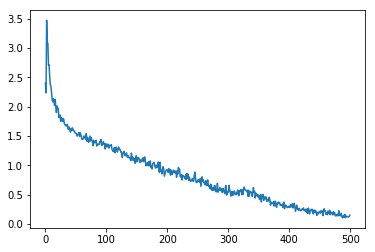

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)

In [28]:
i, o, p = model.test(sess, x, y)

In [29]:
i[0:5]

array([[ 3,  8,  5,  5,  9],
       [10,  4,  6,  3,  3],
       [ 7,  5,  1,  3, 10],
       [ 8,  6,  5,  7,  2],
       [ 7,  1,  4,  9,  3]])

In [30]:
o[0:5]

array([[ 9,  5,  5,  8,  3,  0],
       [ 3,  3,  6,  4, 10,  0],
       [10,  3,  1,  5,  7,  0],
       [ 2,  7,  5,  6,  8,  0],
       [ 3,  9,  4,  1,  7,  0]])

In [31]:
p[0:5]

array([[ 9,  5,  5,  8,  3,  0],
       [ 3,  3,  6,  4, 10,  0],
       [10,  3,  1,  5,  7,  0],
       [ 2,  7,  5,  6,  8,  0],
       [ 3,  9,  4,  7,  7,  0]], dtype=int32)

In [ ]:
fd = model.get_batch(x,y)

In [ ]:
a, b = sess.run([model.training_logits, model.inference_logits], fd)

In [ ]:
a1 = np.argmax(a, -1)

In [ ]:
a1.T[0:5]

In [ ]:
b.T[0:5]

In [ ]:
c = remove_type(a, 1)

In [ ]:
c[0:5]

In [ ]:
list1 = [2, 3, 4, 1]

In [ ]:
list1[-1]

In [ ]:
list1[-3]

In [ ]:
y